In [1]:
#YES
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.tools as tl 
import os

In [2]:
#YES
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
#Loading of LUNG data
name = "H"
lung_file = ".\data\Lung\GSE122960_RAW\GSM3489182_Donor_01_filtered_gene_bc_matrices_h5.h5"
#read files into adata format
adata = sc.read_10x_h5(lung_file)
adata

In [ ]:
#Loading of BLADDER data
#ALL TSV FILES AND MTX FILES MUST BE IN THE SAME FOLDER FOR read_10x_mtx to read properly
name = "D"
bladder_file = ".\data\Bladder\collated_data"
adata = sc.read_10x_mtx(bladder_file,var_names='gene_symbols')
adata

In [3]:
#Loading of Ileum data
#JESUS CHRIST, MTX ON READS AND NEEDS FILES WITH THE NAMES
# barcodes.tsv,genes.tsv,and matrix.mtx EXCLUSIVELY
name = "Y"
ileum_file = ".\data\Ileum\collated_data"
adata = sc.read_10x_mtx(ileum_file,var_names='gene_symbols')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [ ]:
#Divya's +Yu  code doesnt have this
#Check for duplicated names
dup_genes = adata.var_names[adata.var_names.duplicated()].tolist()
print(dup_genes)
print(len(dup_genes))


# if name == "H":
#     adata.var[adata.var.index.duplicated(keep=False)] 


In [4]:
#YES
#make duplicated genes
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 737280 × 33694
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


c:\Users\zhang\Desktop\Python presentation\scan\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


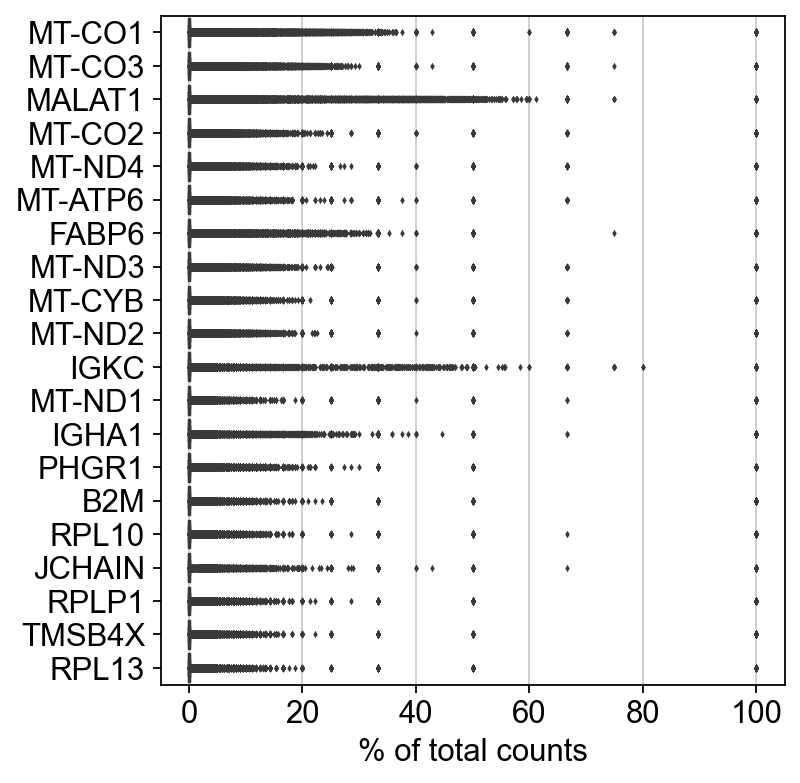

In [5]:
#YES
#show genes that yield highest fraction of counts in each single cell, across all cells
#Divya's code sets n_top=500

sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:
#Divya's code does not filter, she says it doesnt make any difference filtered or non-filtered
#i think this part of the code filters ACE2 out of divyas data


if name in ["H","Y"]:
    # remove cells with less than 200 genes expressed
    sc.pp.filter_cells(adata, min_genes=200)

    # remove genes that are expressed in less than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)

filtered out 731043 cells that have less than 200 genes expressed
filtered out 15416 genes that are detected in less than 3 cells


In [7]:
#YES
# to filter mito genes, annotate them (start with "MT-") first 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# for each cell compute fraction of counts in mito genes vs. all genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

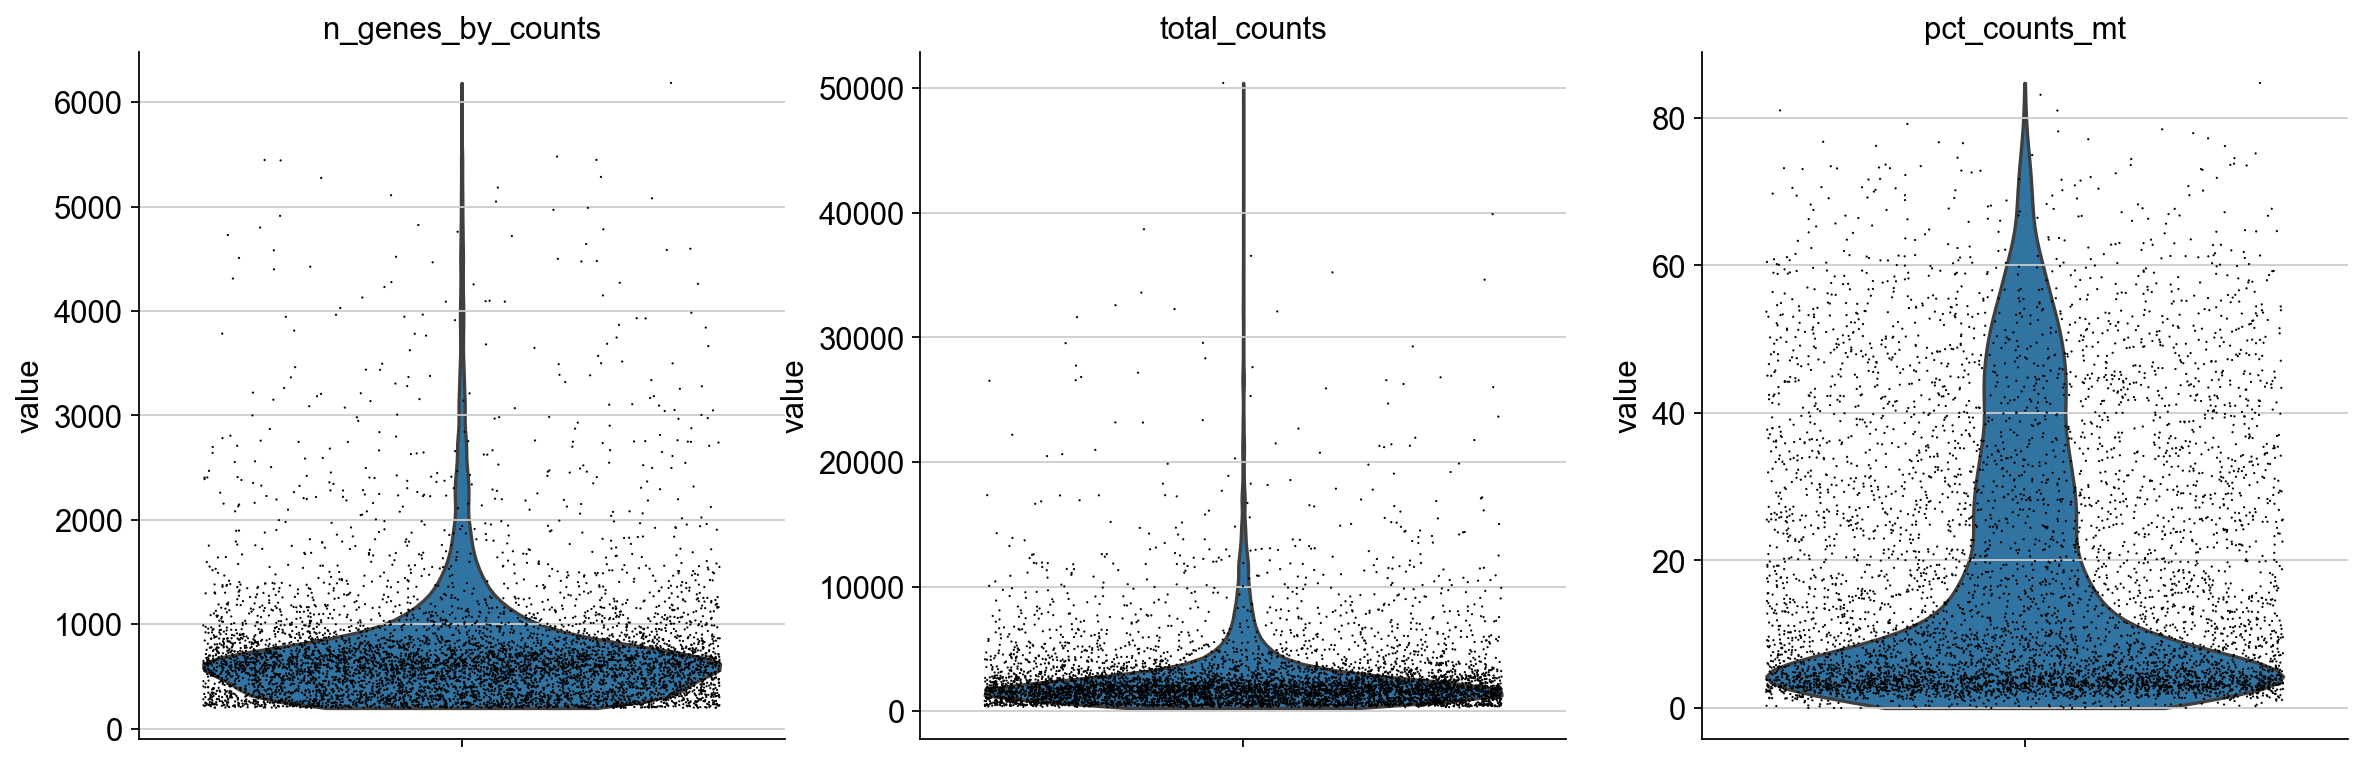

In [8]:
#YES
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True) # plots fields of .obs (cells)

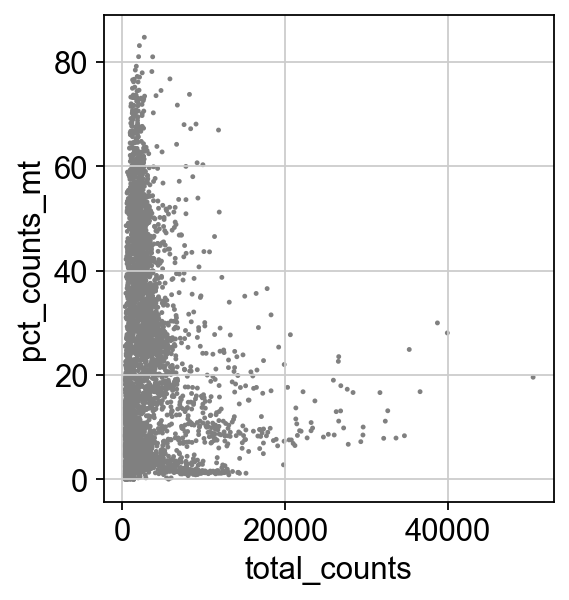

In [9]:
#YES
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
 

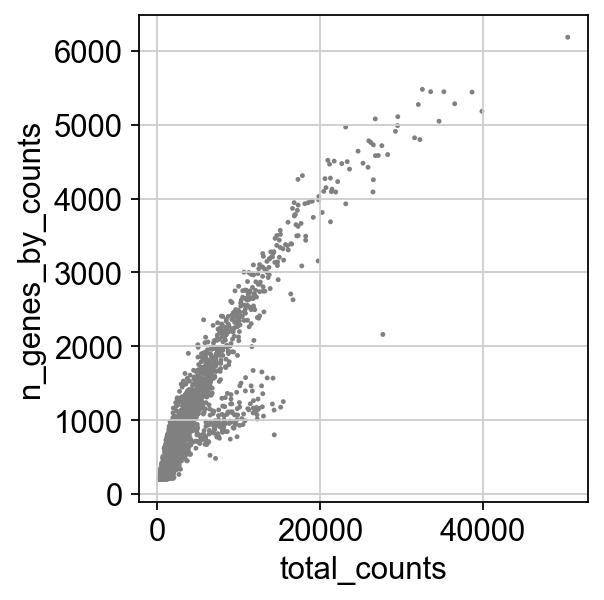

In [10]:
#YES
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
#Divya can filter

# filter out cells with more than 3000 genes or less than 10% mito gene umi counts (cut-offs are set based on the violin and scatter plots)
#Divyas code uses 2500 and 5 as the cutoff

if name =="H":
    #Helena
    adata = adata[adata.obs.n_genes_by_counts < 3000, :] 
    adata = adata[adata.obs.pct_counts_mt < 10, :]
elif name in ["D","Y"]:
#Divya
    adata = adata[adata.obs.n_genes_by_counts < 2500, :] 
    adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
#YES
sc.pp.normalize_total(adata, target_sum=1e4) # flavor='seurat_v3' expects raw count data
sc.pp.log1p(adata) # flavor='seurat_v3' expects raw count data

normalizing counts per cell
    finished (0:00:00)


c:\Users\zhang\Desktop\Python presentation\scan\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
#YES

# # according to the tutorial above, flavor="cell_ranger" is consistent with Seurat
# #Divya's code doesnt have the last 3 variables
# #didn't include last 3 variables in main
# if name == "H":
#     # #Helena
#     sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, 
#                                 n_top_genes = 2000, flavor = "cell_ranger", n_bins = 20)

# #Divya's data fails using Helena's code
# elif name in ["D","Y"]:
# #Divya
#     sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


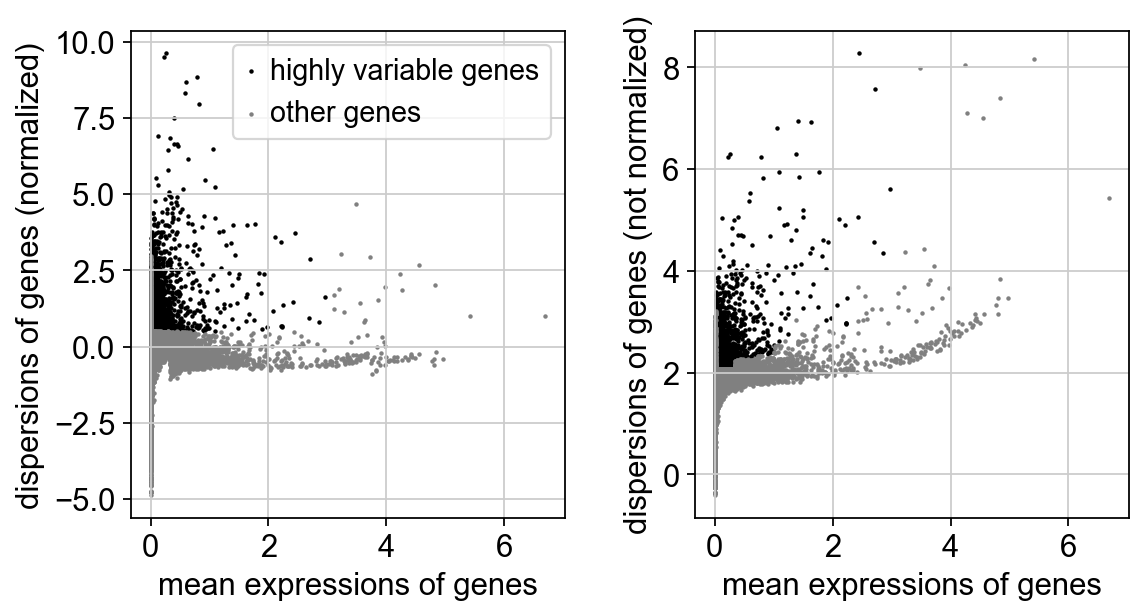

In [14]:
#YES
sc.pl.highly_variable_genes(adata)

In [ ]:
#YES

# check how many genes were determined to be highly variable
# .value_counts() function counts a series containing counts of unique values

adata.var.highly_variable.value_counts()

In [15]:
#Divya and Yu have this in main code
#NECESSARY
adata.raw = adata

In [ ]:
# #??? I don't get why this is necessary
# adata_raw = adata
# # adata_raw.write("drive/MyDrive/lung_results/lung_results_file_raw")
# adata_raw.write(".\data\lung_results_file_raw")
# adata_raw

In [16]:
# filter the genes, only keeping the highly variable ones

adata = adata[:, adata.var.highly_variable]
# adata

In [17]:
#YES

# regress out effects of total counts per cell and % of mito genes expressed

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [18]:
#YES

# scale each gene to unit variance. Clip values exceeding sd 10

sc.pp.scale(adata, max_value=10)

In [19]:
#YES

# reduce the dimensionality of the data by running principal component analysis (PCA)
# PCA identifes the main axes of variation

sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


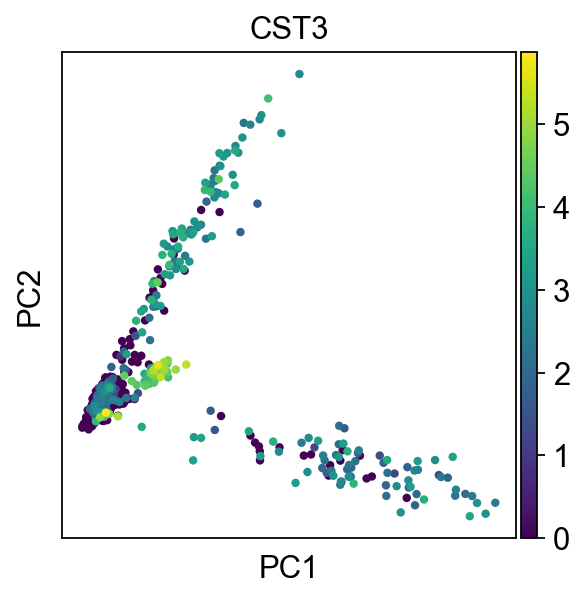

In [20]:
#YES

# plot the first two principal components

if name == "H":
    #Helena's code
    sc.pl.pca(adata, color='SFTPB')
elif name =="D":
    #Divya's code
    #CURRENTLY CAN'T FIND ACE2
    sc.pl.pca(adata, color='ACE2')
elif name =="Y":
    #Yu's code
    #CURRENTLY CAN'T FIND ACE2
    sc.pl.pca(adata, color='CST3')

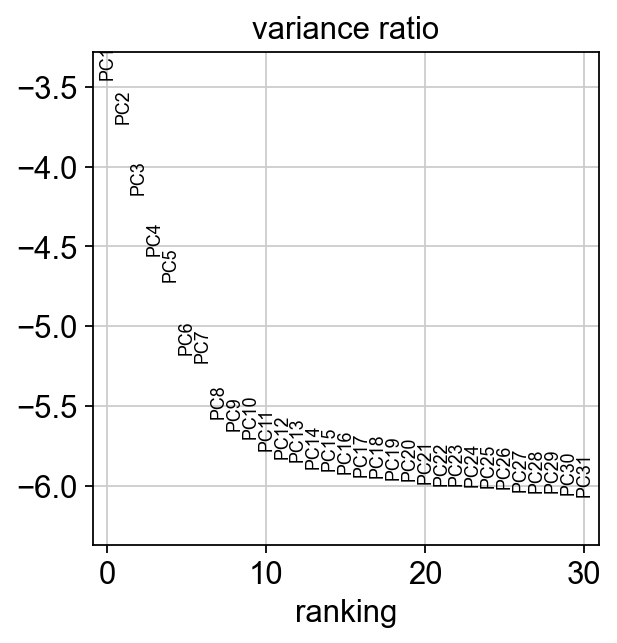

In [21]:
#YES

# inspect the contribution of single PCs to the total variance in the data
# this gives an idea of how many PCs to consider when computing the neighborhood relations of cells (e.g. used in the clustering function sc.tl.louvain())

sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# # save the result
# ##?? is this necessary?

# adata.write(".\data\\resuklts_file_cellranger")

In [22]:
#YES

# compute the neighborhood graph
# Divya's data has neighbours as 10 and pcs as 40
if name == "H":
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30) 

elif name =="D":
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
elif name == "Y":
    sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50


c:\Users\zhang\Desktop\Python presentation\scan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


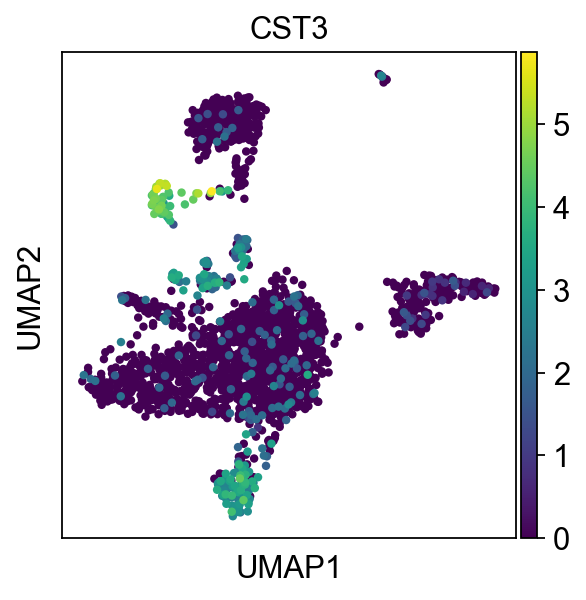

In [23]:
#YES

sc.tl.umap(adata)
sc.pl.umap(adata, color='CST3')

In [24]:
#YES

# As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity)
sc.tl.leiden(adata) 

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


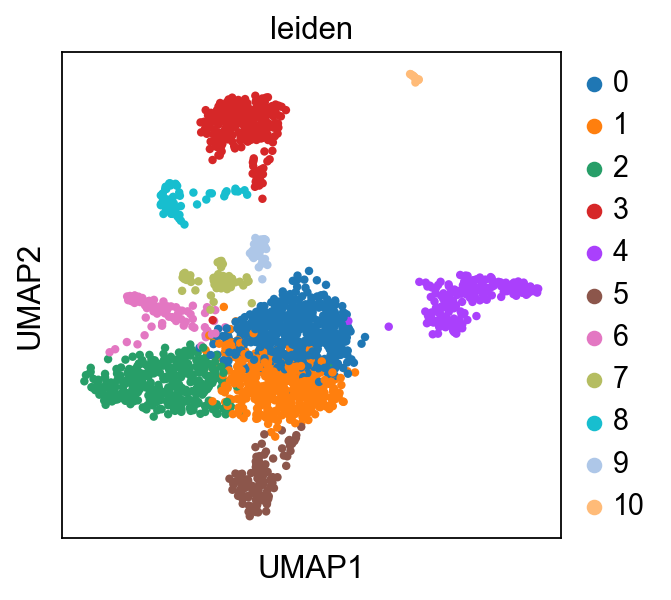

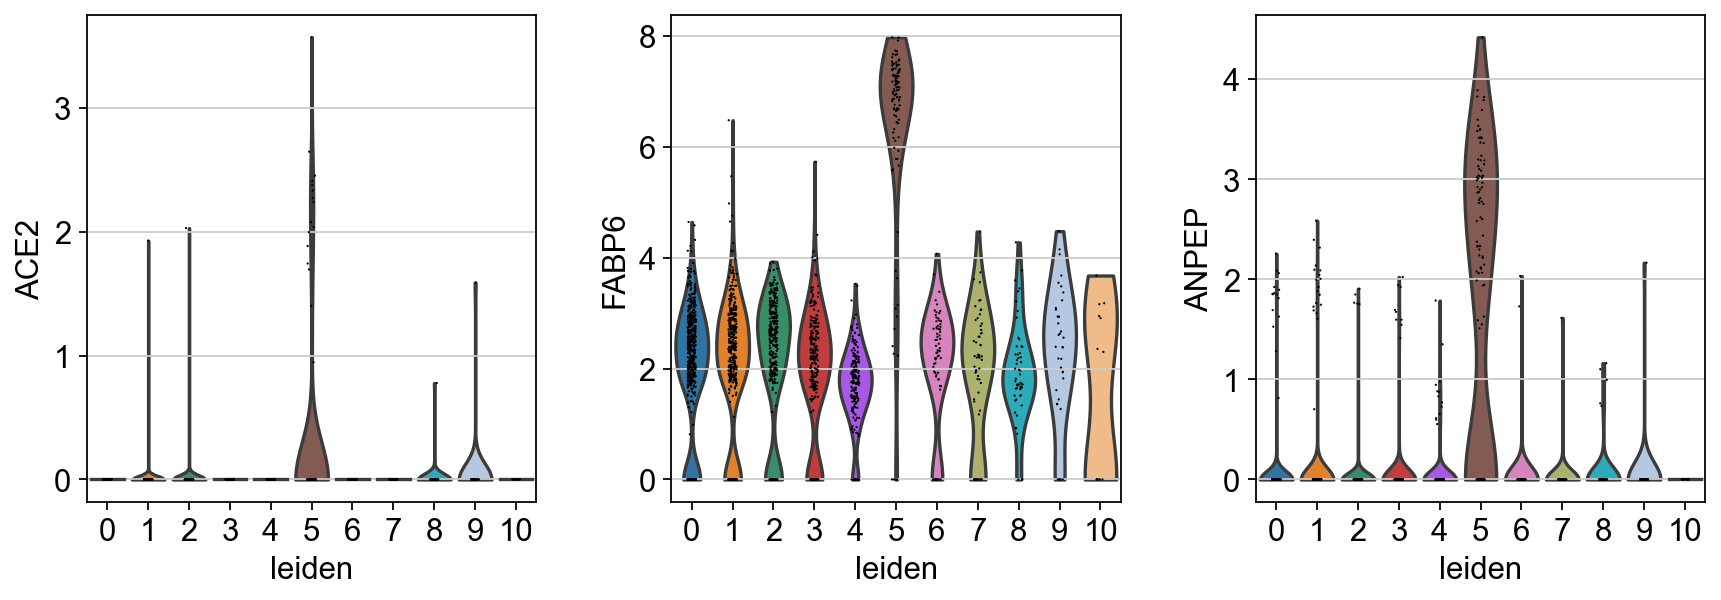

In [26]:
#extra from Yu
sc.pl.umap(adata,color='leiden')
sc.pl.violin(adata,['ACE2','FABP6','ANPEP'], groupby='leiden')

In [ ]:
#YES
#Yu's code dpesn't have this
# embed the neighborhood graph in two dimensions using UMAP

tl.paga(adata) 
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

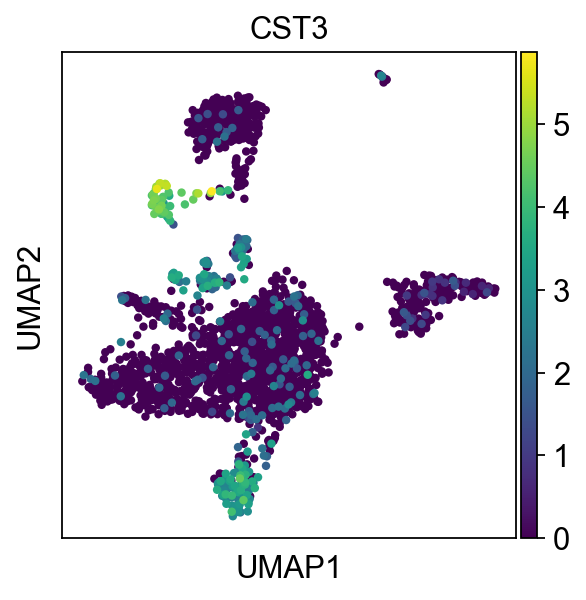

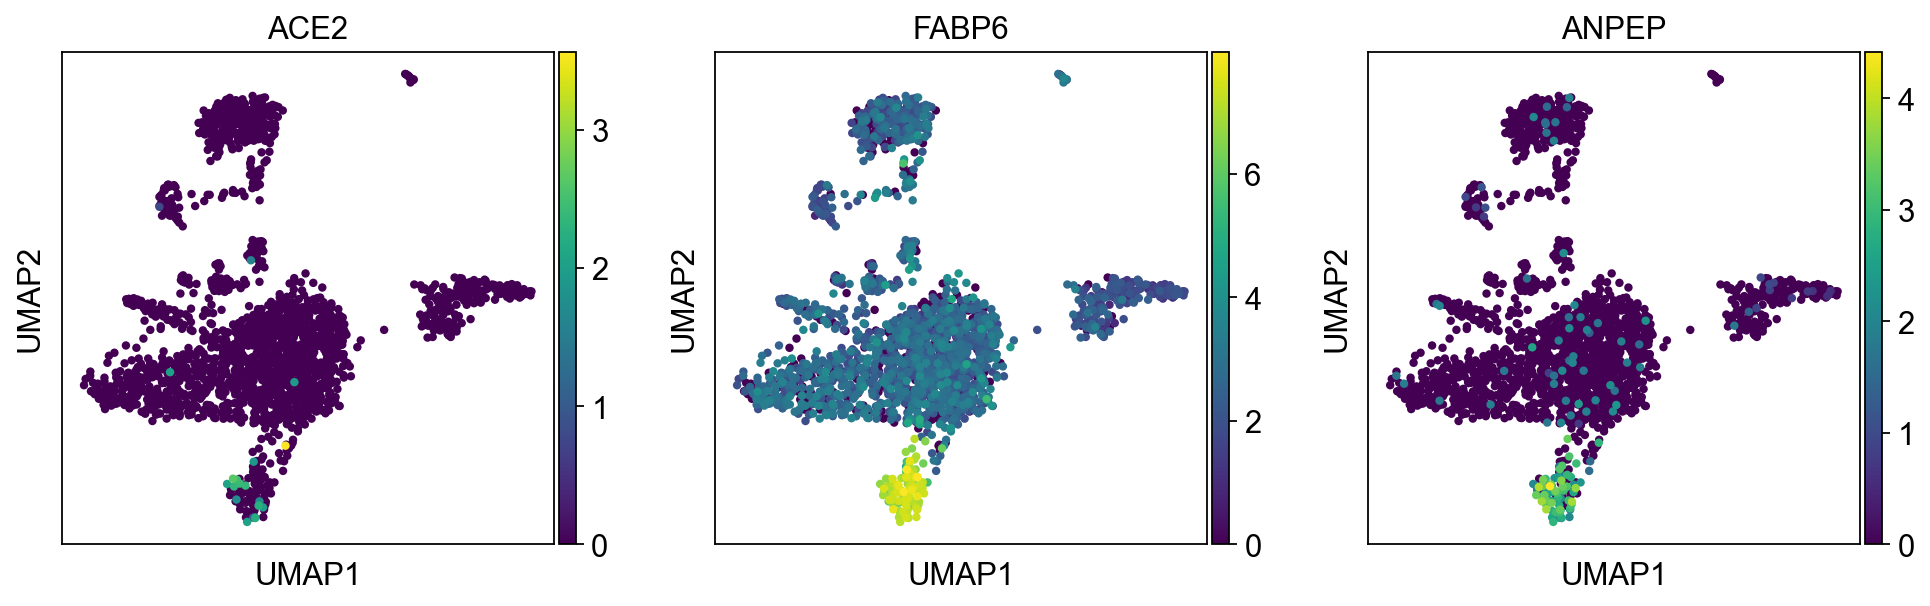

In [27]:
#YES


# plot umap
if name =="H":
#Helena
    sc.pl.umap(adata, color=["leiden", 'SFTPB', 'SFTPC', 'ACE2'], wspace=0.4) # wspace is for spacing between multiple umaps. Lung dataset have a lot of clusters, legend overlaps with the next umap if you don't adjust this.
    sc.pl.violin(adata, ['SFTPB', 'SFTPC', 'ACE2'], groupby='leiden')
# 'SFTPB', 'SFTPC' genes are canonical markers of AT2 cells
# cluster 1, 2, 3 seem to be the AT2 cells
elif name =="D":
#Divya
    sc.pl.umap(adata, color=['SPINK1','leiden','CLDN4','ACE2'])
#Divya
    # sc.pl.umap(adata, color=['SPINK1','CLDN4','ACE2'])
elif name =="Y":
    sc.pl.umap(adata, color='CST3')
    sc.pl.umap(adata, color=['ACE2', 'FABP6', 'ANPEP'])

In [ ]:
#Helena
sc.pl.violin(adata, ['SFTPB', 'SFTPC', 'ACE2'], groupby='leiden')